In [1]:
!pip install rouge-score  

  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=974ca73d6250035eb4fc0d7e62082f7f7c528b0d512dcfd0c9e0e0b6a1777db3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import pandas as pd
import transformers
from torch.utils.data import Dataset, DataLoader


from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name)

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# sum_dir = "/kaggle/working/1aoROkMxdPLanin2KyfJuBSYti3EnpI3J?usp=sharing" # location to store and load models

In [4]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
#EPOCHS = 1
LEARNING_RATE = 1e-05

# load dataframes containining preprocessed samples from CNN/Dailymail Dataset
train_df = pd.read_json("/kaggle/input/datasetfinal/train_bdf.json")
test_df = pd.read_json("/kaggle/input/datasetfinal/test_bdf.json")
print( "Train, test shape", train_df.shape, test_df.shape)

Train, test shape (119634, 3) (33246, 3)


In [5]:
train_df

,sents,docs,y
3,The diocese announced on Monday that Bishop Jo...,"By. Associated Press. PUBLISHED:. 14:11 EST, 2...",1
4,The diocese says he contracted the infection t...,"By. Associated Press. PUBLISHED:. 14:11 EST, 2...",1
9,A criminal complaint unsealed in U.S. District...,(CNN) -- Ralph Mata was an internal affairs li...,0
14,"Mata, according to the complaint, then used co...",(CNN) -- Ralph Mata was an internal affairs li...,0
24,Police said Eccleston-Todd had drunk at least ...,A drunk driver who killed a young woman in a h...,1
...,...,...,...
1278789,According to WPTV the pair admitted to killing...,A Florida man and his girlfriend allegedly bro...,1
1278794,Charged: Adams and Curran are believed to have...,A Florida man and his girlfriend allegedly bro...,0
1278807,The 'star' of the show: Executive producer Mar...,Chicago is no stranger to corruption so perhap...,0
1278815,Producers Levin and Benjamin are both represen...,Chicago is no stranger to corruption so perhap...,1


In [6]:
# Create a Data Loader Class
class CNNDailyMailData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].sents)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].docs)
        document = " ".join(document.split())

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document],
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_ids': torch.tensor(ids[0], dtype=torch.long),
            'doc_ids': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'targets': torch.tensor([self.data.iloc[index].y], dtype=torch.long)
        }

    def __len__(self):
        return self.len



training_set = CNNDailyMailData(train_df, tokenizer, MAX_LEN)
testing_set = CNNDailyMailData(test_df, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [7]:
# get mean pooling for sentence bert models
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.
# Note that different sentence transformer models may have different in_feature sizes
class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2", in_features=384):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(in_features*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask)
        sentence_embeddings = mean_pooling(sent_output, sent_mask)

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask)
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings

        # Concatenate input features and their elementwise product
        concat_features = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)

        pooler = self.pre_classifier(concat_features)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output)

        return output

In [8]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

model = SentenceBertClass(model_name=sentenc_model_name)
model.to(device);

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

pytorch_model.bin:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

In [9]:
!pip install rouge
import torch
import json
from rouge import Rouge

def calculate_rouge_score(hypothesis, reference):
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference, avg=True)
    return scores

In [10]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
print_n_steps = 1000
EPOCHS = 5
acc_step_holder, loss_step_holder = [], []


def train(epoch):    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    hypotheses, references = [], []
    for _, data in tqdm(enumerate(training_loader, 0)):
        sent_ids = data['sent_ids'].to(device, dtype=torch.long)
        doc_ids = data['doc_ids'].to(device, dtype=torch.long)
        sent_mask = data['sent_mask'].to(device, dtype=torch.long)
        doc_mask = data['doc_mask'].to(device, dtype=torch.long) 
        targets = data['targets'].to(device, dtype=torch.float)  

        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() 
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        str_1 = json.dumps(outputs.tolist())
        str_2 = json.dumps(targets.tolist())
        hypotheses.append(str_1)
        references.append(str_2)

        if _ % print_n_steps == 0:
            loss_step = tr_loss / nb_tr_steps
            accu_step = (n_correct * 100) / nb_tr_examples 
            acc_step_holder.append(accu_step)
            loss_step_holder.append(loss_step)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_rouge_scores_train = calculate_rouge_score(hypotheses, references)
    print(f'Rouge Score after Epoch {epoch + 1}: {avg_rouge_scores_train}')

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct * 100) / nb_tr_examples}')
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [11]:
# evaluate_every_n_epochs = 1
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Rouge Score after Epoch 1: {'rouge-1': {'r': 0.3520228025008444, 'p': 0.27149854558824776, 'f': 0.3057162739307092}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.3520228025008444, 'p': 0.27149854558824776, 'f': 0.3057162739307092}}
The Total Accuracy for Epoch 0: 70.82769112459668
Training Loss Epoch: 0.559928595504838
Training Accuracy Epoch: 70.82769112459668


0it [00:00, ?it/s]

Rouge Score after Epoch 2: {'rouge-1': {'r': 0.35217994583562917, 'p': 0.27185239671444306, 'f': 0.3060048766293432}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.35217994583562917, 'p': 0.27185239671444306, 'f': 0.3060048766293432}}
The Total Accuracy for Epoch 1: 74.8198672618152
Training Loss Epoch: 0.5090144572380277
Training Accuracy Epoch: 74.8198672618152


0it [00:00, ?it/s]

Rouge Score after Epoch 3: {'rouge-1': {'r': 0.352512621618837, 'p': 0.27195827342936635, 'f': 0.3061951507653244}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.352512621618837, 'p': 0.27195827342936635, 'f': 0.3061951507653244}}
The Total Accuracy for Epoch 2: 78.28710901583162
Training Loss Epoch: 0.4589083197042834
Training Accuracy Epoch: 78.28710901583162


0it [00:00, ?it/s]

Rouge Score after Epoch 4: {'rouge-1': {'r': 0.35222006753812535, 'p': 0.2718551829437831, 'f': 0.306021442024984}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.35222006753812535, 'p': 0.2718551829437831, 'f': 0.306021442024984}}
The Total Accuracy for Epoch 3: 81.76605312870923
Training Loss Epoch: 0.40151715779853214
Training Accuracy Epoch: 81.76605312870923


0it [00:00, ?it/s]

Rouge Score after Epoch 5: {'rouge-1': {'r': 0.3519308569326207, 'p': 0.27179030360343465, 'f': 0.30587326528605263}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.3519308569326207, 'p': 0.27179030360343465, 'f': 0.30587326528605263}}
The Total Accuracy for Epoch 4: 85.01011418158717
Training Loss Epoch: 0.3426366885504825
Training Accuracy Epoch: 85.01011418158717


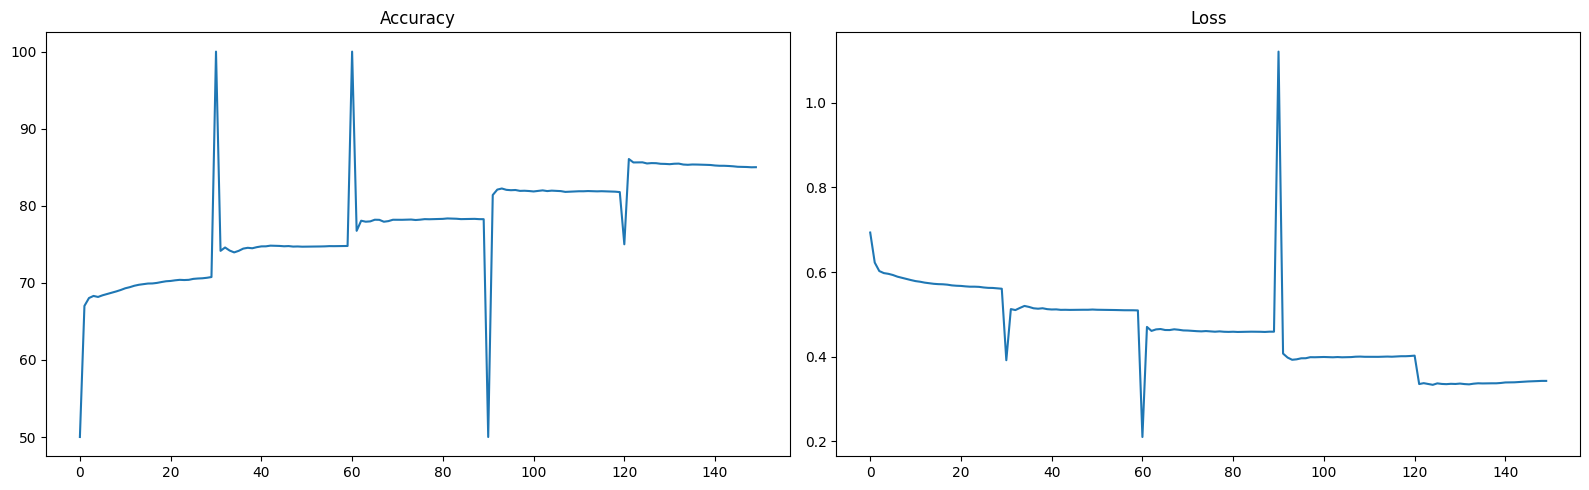

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.plot(acc_step_holder, label="Accuracy")
ax2.plot(loss_step_holder, label="Loss")
ax1.title.set_text("Accuracy")
ax2.title.set_text("Loss")
fig.tight_layout()
plt.show()

In [13]:
def validate_model(model, testing_loader):
    model.eval()

    n_correct = 0; n_wrong = 0; total = 0;  tr_loss = 0; nb_tr_steps = 0 ; nb_tr_examples = 0;
    hypotheses, references = [], []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):

            sent_ids = data['sent_ids'].to(device, dtype = torch.long)
            doc_ids = data['doc_ids'].to(device, dtype = torch.long)
            sent_mask = data['sent_mask'].to(device, dtype = torch.long)
            doc_mask = data['doc_mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(sent_ids, doc_ids, sent_mask, doc_mask)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()

            n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            str_1 = json.dumps(outputs.tolist())
            str_2 = json.dumps(targets.tolist())
            hypotheses.append(str_1)
            references.append(str_2)

            if _%print_n_steps==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                #print(str(_* test_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)

    avg_rouge_scores_train = calculate_rouge_score(hypotheses, references)
    print(f'Rouge Score after Epoch {epoch + 1}: {avg_rouge_scores_train}')
    
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu


In [14]:
acc = validate_model(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

Rouge Score after Epoch 5: {'rouge-1': {'r': 0.35280919153033447, 'p': 0.2725892570695218, 'f': 0.30671463917969727}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.35280919153033447, 'p': 0.2725892570695218, 'f': 0.30671463917969727}}
Validation Loss Epoch: 0.705863656579278
Validation Accuracy Epoch: 70.00842206581243
Accuracy on test data = 70.01%


In [15]:
import pickle
with open('minilm_bal_exsum.pkl', 'wb') as f:
    pickle.dump(model, f)


In [16]:
import pickle
with open('minilm_bal_exsum.pkl', 'rb') as f:
    loaded_model = pickle.load(f)